In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [96]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],"intensity":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("0002" in str(filelist[i]))==True:
            if filelist[i].endswith(".tif"): 
                #if str(filelist[i][:-12]) not in str(results["filename"]):

                    results["filename"].append(filelist[i])
                    results["exp condition"].append(filelist[i].split('/')[-2])
                    #channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                    #exec(open(channeldir+"/channels.txt").read())
                    results["ecmchannelno"].append(1)



In [97]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/1_1_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/1_2_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/1_3_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/2_1_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/2_2_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/1_blocked_bic/2_4_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/2_unblocked_bic/1_1_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic Slices/20191205_organotypic/2_unblocked_bic/1_2_C0002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Organotypic S

In [98]:

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read masks
    original_image_name=results["filename"][image]
    original_image=pims.open(original_image_name)[0]
    inten=np.mean(original_image[original_image<170])
    results["intensity"].append(inten)

Calculating image no 1 out of51
Calculating image no 2 out of51
Calculating image no 3 out of51
Calculating image no 4 out of51
Calculating image no 5 out of51
Calculating image no 6 out of51
Calculating image no 7 out of51
Calculating image no 8 out of51
Calculating image no 9 out of51
Calculating image no 10 out of51
Calculating image no 11 out of51
Calculating image no 12 out of51
Calculating image no 13 out of51
Calculating image no 14 out of51
Calculating image no 15 out of51
Calculating image no 16 out of51
Calculating image no 17 out of51
Calculating image no 18 out of51
Calculating image no 19 out of51
Calculating image no 20 out of51
Calculating image no 21 out of51
Calculating image no 22 out of51
Calculating image no 23 out of51
Calculating image no 24 out of51
Calculating image no 25 out of51
Calculating image no 26 out of51
Calculating image no 27 out of51
Calculating image no 28 out of51
Calculating image no 29 out of51
Calculating image no 30 out of51
Calculating image n

In [99]:
df_ecm=pd.DataFrame(results)

In [100]:
df_ecm["Cond"]="None"
df_ecm.loc[df_ecm["filename"].str.contains("blocked"),"Cond"]="Blocked"
df_ecm.loc[df_ecm["filename"].str.contains("unblocked"),"Cond"]="Unblocked"

df_ecm["Drug"]="None"
df_ecm.loc[df_ecm["filename"].str.contains("bic"),"Drug"]="Bic"
df_ecm.loc[df_ecm["filename"].str.contains("dmso"),"Drug"]="DMSO"

4.088590726257129e-11


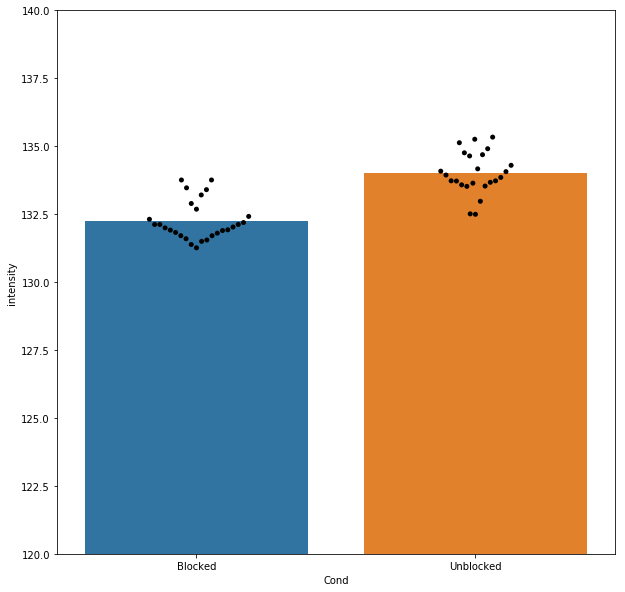

In [101]:
plt.figure(figsize=(10,10))

sns.barplot(x="Cond",y="intensity",data=df_ecm,ci=None)
sns.swarmplot(x="Cond",y="intensity",data=df_ecm,color="black")
plt.ylim(120,140)

var="intensity"
blocked=df_ecm[df_ecm["Cond"]=="Blocked"][var].dropna()
unblocked=df_ecm[df_ecm["Cond"]=="Unblocked"][var].dropna()
[statis,pal]=stats.ttest_ind(blocked,unblocked)
print(pal)

(120, 150)

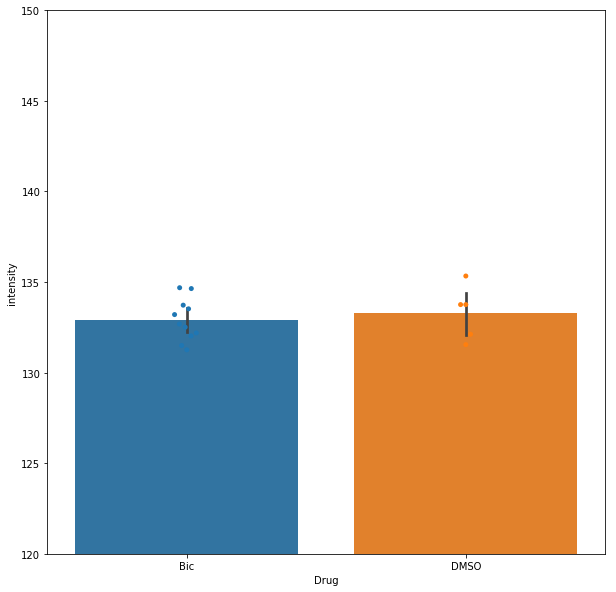

In [91]:
plt.figure(figsize=(10,10))
sns.barplot(x="Drug",y="intensity",data=df_ecm)
sns.swarmplot(x="Drug",y="intensity",data=df_ecm)
plt.ylim(120,150)

